# Image Classification

### Import packages and libraries required for the project

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

### Upload and Load the caltech-101 dataset

In [2]:
caltech101_path = '../data/caltech-101/101_ObjectCategories'

### Create list image_data and labels to store the image paths and image labels

In [3]:
image_data = []
labels = []

### Loop through the list of all the directories and store the image paths in image_data and image labels in labels

In [4]:
for class_name in os.listdir(caltech101_path):
    class_path = os.path.join(caltech101_path, class_name)
    
    if os.path.isdir(class_path):
        for image_file in os.listdir(class_path):
            if image_file.endswith('.jpg'):
                image_path = os.path.join(class_path, image_file)
                image_data.append(image_path)
                labels.append(class_name)

In [5]:
print("Total number of samples:", len(image_data))

Total number of samples: 9144


## **Split train and test sets**

### Split the train and test sets randomly using train_test_split function with parameters image_data, labels, test_size=0.2

In [6]:
train_data, test_data, train_labels, test_labels = train_test_split(
    image_data, labels, test_size=0.1, random_state=42, stratify=labels
)

### Create objects directory to store the train and test directories.

In [199]:
train_test_root = '../data/caltech-101/objects'

### Create the path for train and test directories with the names train and test

In [8]:
train_dir = os.path.join(train_test_root, 'train')
test_dir = os.path.join(train_test_root, 'test')

### Check train and test directories are existing

In [9]:
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

### Define a function copy_images to copy the images of train data to train directory and test data to test directory

In [10]:
def copy_images(src_paths, dest_dir):
    for src_path in src_paths:
        class_name = os.path.basename(os.path.dirname(src_path))
        dest_class_dir = os.path.join(dest_dir, class_name)
        os.makedirs(dest_class_dir, exist_ok=True)

        dest_path = os.path.join(dest_class_dir, os.path.basename(src_path))

        with open(src_path, 'rb') as src_file:
            # Write the content to the destination file
            with open(dest_path, 'wb') as dest_file:
                dest_file.write(src_file.read())

copy_images(train_data, train_dir)

copy_images(test_data, test_dir)

### Data augmentation

It involves applying various transformations to the existing dataset to artificially increase its size, diversity, and improve the model's generalization. Augmentation techniques include rotation, flipping, scaling, translation, shearing, and changes in brightness and contrast.


### Apply Data Augmentation for the training set using ImageDataGenerator with parameters rescale, shear_range, zoom_range, horizontal_flip

In [196]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

### Configure ImageDataGenerator for normalizing test data by rescaling pixel values to the range [0, 1].


In [12]:
test_datagen = ImageDataGenerator(rescale=1./255)

### Use flow_from_directory to generate batches of augmented and normalized images from the train directory

In [170]:
batch_size = 120  
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=True
)

Found 8229 images belonging to 102 classes.


### Use flow_from_directory to generate batches of normalized images from the test directory

In [122]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  
)

Found 915 images belonging to 102 classes.


## VGG16 Architecture

VGG16 architecture is characterized by a deliberate design choice, emphasizing simplicity with a focus on 3x3 convolutional layers using a stride of 1 and always employing same padding. The consistent pattern of convolution layers followed by 2x2 max-pooling layers with a stride of 2 is maintained throughout the entire structure. The term "16" in VGG16 denotes the presence of 16 layers with trainable weights. The network concludes with two fully connected layers and a softmax activation for output. VGG16 is a substantial model, boasting around 138 million parameters.

### Load VGG16 as the vgg16_model with ImageNet weights, excluding top layers, and set input shape to (224, 224, 3).

In [15]:
from tensorflow.keras.applications import VGG16
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

### Freeze all the layers of the vgg16_model

In [16]:
for layer in vgg16_model.layers:
    layer.trainable = False

### Built a sequential model on top of VGG16 with a flatten layer, a dense layer, a dropout layer , and a final dense layer 


In [17]:
model = models.Sequential()
model.add(vgg16_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(102, activation='softmax'))  


### Compile the model using the Adam optimizer, categorical cross-entropy loss function, and accuracy as the evaluation metric.


In [18]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Train the model using model.fit with training generator, test generator, and specified number of epochs.


In [19]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size
)

Epoch 1/10


68/68 [==============================] - 2696s 40s/step - loss: 3.2756 - accuracy: 0.3272 - val_loss: 2.2600 - val_accuracy: 0.5071
Epoch 2/10
68/68 [==============================] - 1756s 26s/step - loss: 2.2757 - accuracy: 0.4805 - val_loss: 1.5904 - val_accuracy: 0.6512
Epoch 3/10
68/68 [==============================] - 1198s 18s/step - loss: 1.8038 - accuracy: 0.5627 - val_loss: 1.2644 - val_accuracy: 0.7238
Epoch 4/10
68/68 [==============================] - 1188s 17s/step - loss: 1.5497 - accuracy: 0.6070 - val_loss: 0.9811 - val_accuracy: 0.7690
Epoch 5/10
68/68 [==============================] - 1199s 18s/step - loss: 1.3299 - accuracy: 0.6558 - val_loss: 0.8932 - val_accuracy: 0.7952
Epoch 6/10
68/68 [==============================] - 1192s 18s/step - loss: 1.2065 - accuracy: 0.6784 - val_loss: 0.7985 - val_accuracy: 0.7952
Epoch 7/10
68/68 [==============================] - 1187s 17s/step - loss: 1.1130 - accuracy: 0.6992 - val_loss: 0.7677 - val_accuracy: 0.80

### Evaluate the model on test generator to obtain test loss and accuracy 

In [20]:
test_loss, test_acc = model.evaluate(test_generator)

8/8 [==============================] - 263s 33s/step - loss: 0.6681 - accuracy: 0.8317


## Graph Plotting

### Plot model accuracy over epochs using training and test data.


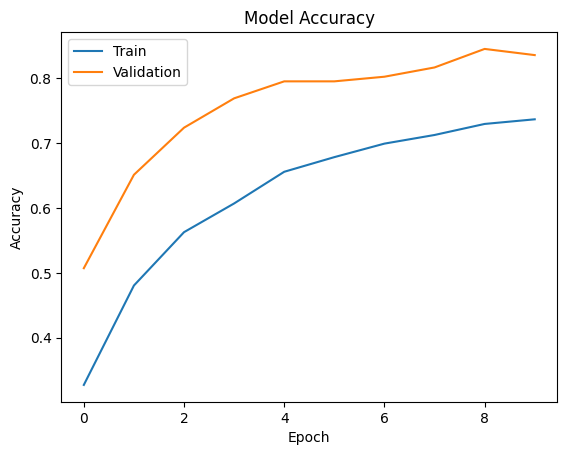

In [84]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Plot model loss over epochs using training and test data.

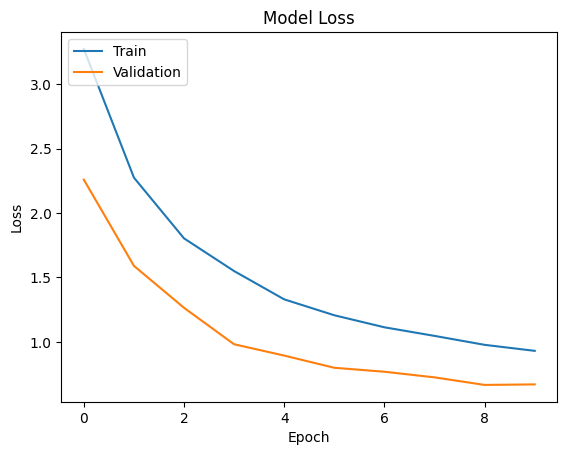

In [85]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Testing Model with the image input

### Define the path of the test image to the variable test_image_path

In [74]:
image_path = '../data/test_image_1.jpg'

### Load the image in the test_image_path and resize it to the target size that is (224,224)

In [75]:
img = image.load_img(image_path, target_size=(224, 224))

### Convert the image to a numpy array using img_to_array() method

In [76]:
img_array = image.img_to_array(img)

### Expand the dimensions of the array to match the input shape of the model

In [77]:
img_array = np.expand_dims(img_array, axis=0)

### Preprocess the image, in this it normalizes the pixel values in the test_img_array NumPy array by dividing each element by 255.0

In [78]:
img_array = img_array / 255.0

### Make predictions using the trained model. The model takes the preprocessed image data (test_img_array) as input and produces predictions or output values

In [79]:
predictions = model.predict(img_array)

1/1 [==============================] - 0s 231ms/step


### Get the class label with the highest probability using function argmax() to determine the index of the highest value in the prediction array, which identify the class or category with the highest predicted probability from the model's output.

In [80]:
predicted_class = np.argmax(predictions)

### class_indices retrieves the dictionary of class indices from the train_generator.

In [81]:
class_indices = train_generator.class_indices

### Get the class label corresponding to the predicted class. In this we iterate through the class_indices dictionary, searching for the key-value pair where the value matches the predicted_class.

In [200]:
predicted_label = [k for k, v in class_indices.items() if v == predicted_class][0]

### Print the predicted label and the image

The predicted label is: ant


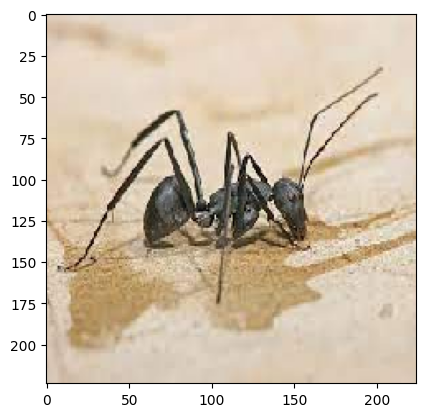

In [198]:
print(f'The predicted label is: {predicted_label}')
plt.imshow(img)